In [191]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import corner
import scipy.stats as st
from statistics import mean, stdev
from collections import Counter
from math import floor,ceil

In [197]:
file_path = 'Datasets/mt_genes_metadata.csv'

met = pd.read_csv(file_path)

pro_code=met[met['gene_type']=='protein_coding']
intpro=pro_code['gene_name'].tolist()
intpro=['MT-ND1','MT-ND2','MT-ND3','MT-ND4','MT-ND4L','MT-ND5','MT-ND6', 'MT-CO1', 'MT-CO2','MT-CO3', 'MT-ATP6', 'MT-ATP8', 'MT-CYB']
intpro

['MT-ND1',
 'MT-ND2',
 'MT-ND3',
 'MT-ND4',
 'MT-ND4L',
 'MT-ND5',
 'MT-ND6',
 'MT-CO1',
 'MT-CO2',
 'MT-CO3',
 'MT-ATP6',
 'MT-ATP8',
 'MT-CYB']

In [198]:
file_path = 'Datasets/Donor1_CD4_Genes.csv'

p14 = pd.read_csv(file_path)

p14.drop(columns=p14.columns[0], axis=1, inplace=True)

p14_int=pd.DataFrame([p14[i] for i in intpro]).T

In [199]:
p14n=len(p14_int)
#p18n=len(p18_int)
#p24n=len(p24_int)
#p28n=len(p28_int)

In [200]:
p14=p14.drop(p14[p14_int.sum(axis=1)==0].index)
p14.index=range(len(p14))

p14_int=p14.drop(p14_int[p14_int.sum(axis=1)==0].index)
p14_int=pd.DataFrame([p14_int[i] for i in intpro]).T
p14_int.index=range(len(p14_int))


In [201]:
p14_intsampto=p14_int.sum(axis=1)
#p18_intsampto=p18_int.sum(axis=1)
#p24_intsampto=p24_int.sum(axis=1)
#p28_intsampto=p28_int.sum(axis=1)

#Calculates the number of genes for each DNA
p14_allsampto=p14.sum(axis=1)
#p18_allsampto=p18.sum(axis=1)
#p24_allsampto=p24.sum(axis=1)
#p28_allsampto=p28.sum(axis=1)

In [202]:
p14_n1=p14_int.copy(deep=True)
#p18_n1=p18_int.copy(deep=True)
#p24_n1=p24_int.copy(deep=True)
#p28_n1=p28_int.copy(deep=True)

p14_n2=p14.copy(deep=True)
#p18_n2=p18_int.copy(deep=True)
#p24_n2=p24_int.copy(deep=True)
#p28_n2=p28_int.copy(deep=True)

In [203]:
r=100
p14_n1_len=len(p14_n1)
for j in intpro:
    for i in p14_n1.index: 
            norm_cons=(p14_intsampto[i]-p14_n1.loc[i,j])/r #inidividual normalisation constant
            p14_n1.loc[i,j]=p14_n1[j][i]/norm_cons

C:\Users\lizar\AppData\Local\Temp\ipykernel_30520\2469847887.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.47945205479452' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n1.loc[i,j]=p14_n1[j][i]/norm_cons
C:\Users\lizar\AppData\Local\Temp\ipykernel_30520\2469847887.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3157894736842106' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n1.loc[i,j]=p14_n1[j][i]/norm_cons
C:\Users\lizar\AppData\Local\Temp\ipykernel_30520\2469847887.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.6666666666666665' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n1.lo

In [204]:
r=1000
p14_n2_len=len(p14_n2)
for j in intpro:
    for i in p14_n2.index: 
            norm_cons=(p14_allsampto[i]-p14_n2.loc[i,j])/r #inidividual normalisation constant
            p14_n2.loc[i,j]=p14_n2[j][i]/norm_cons

C:\Users\lizar\AppData\Local\Temp\ipykernel_30520\2979221777.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.817589576547232' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n2.loc[i,j]=p14_n2[j][i]/norm_cons
C:\Users\lizar\AppData\Local\Temp\ipykernel_30520\2979221777.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9430051813471503' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n2.loc[i,j]=p14_n2[j][i]/norm_cons
C:\Users\lizar\AppData\Local\Temp\ipykernel_30520\2979221777.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.893575600259572' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  p14_n2.lo

Calculating UEM of proportion parameter at r=100 and r=1000

In [ ]:
r=100
uem14_list_n1=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p14_n1_len):   
        x=p14_n1[j][i]
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem14_list_n1.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_4'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem14_list_n1=dict(zip(intpro,uem14_list_n1))

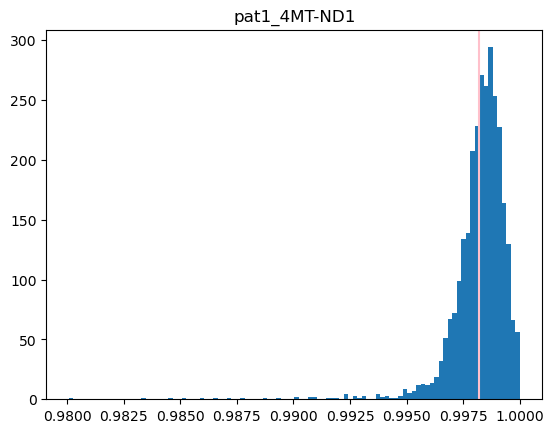

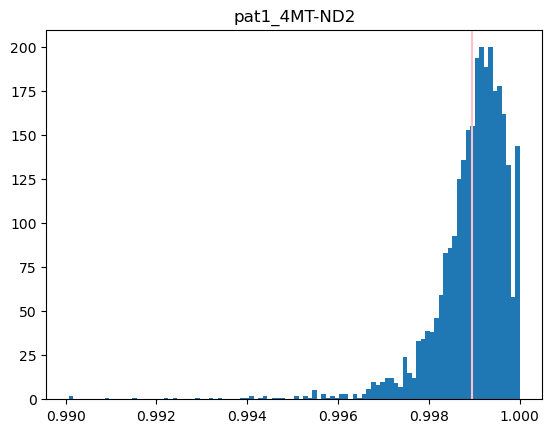

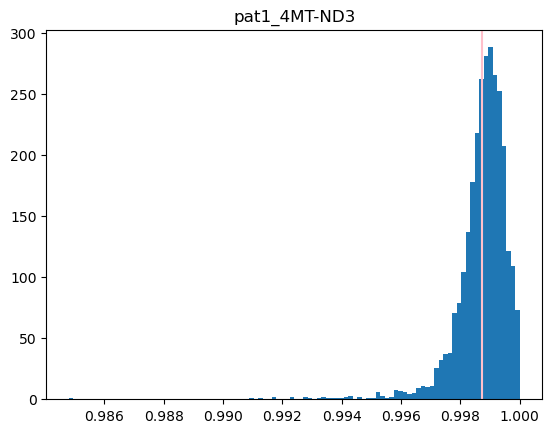

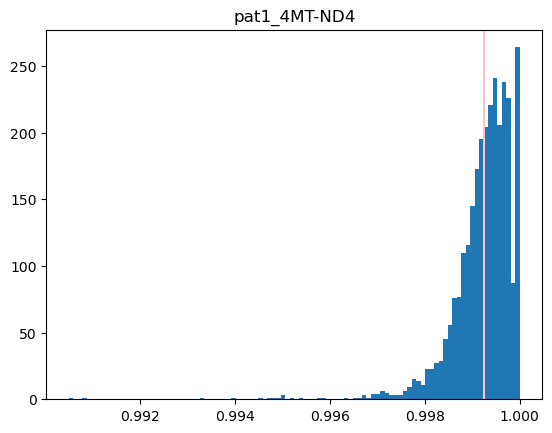

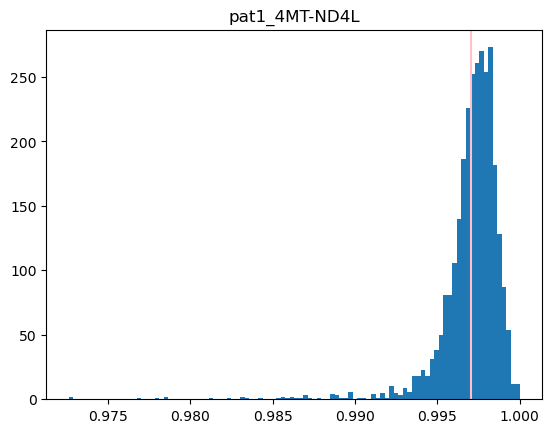

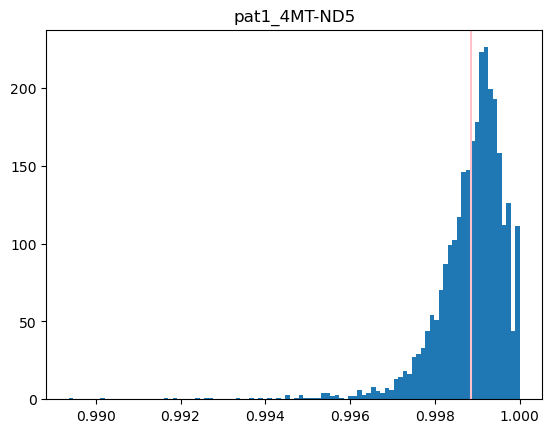

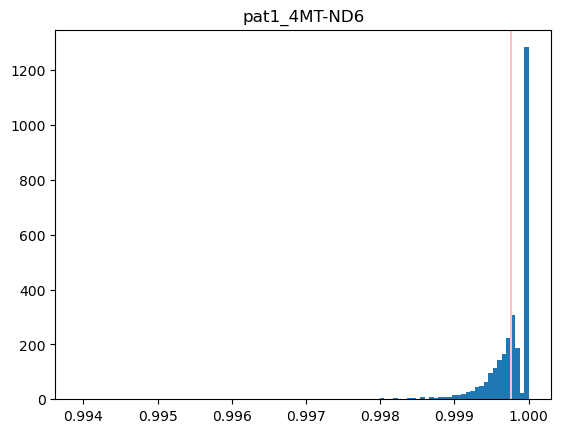

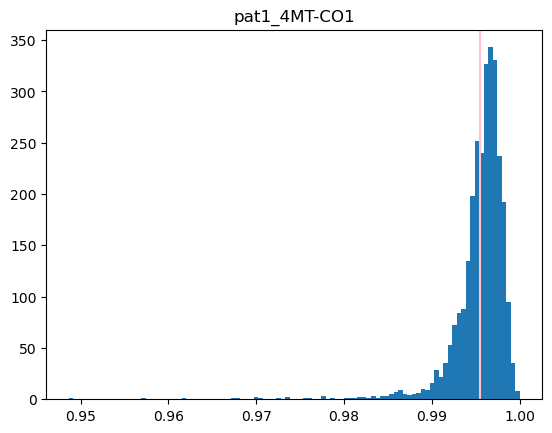

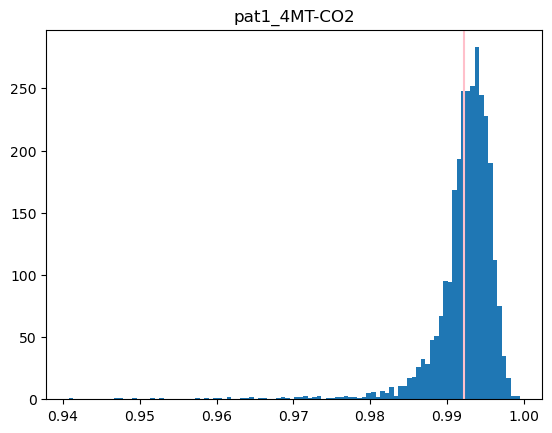

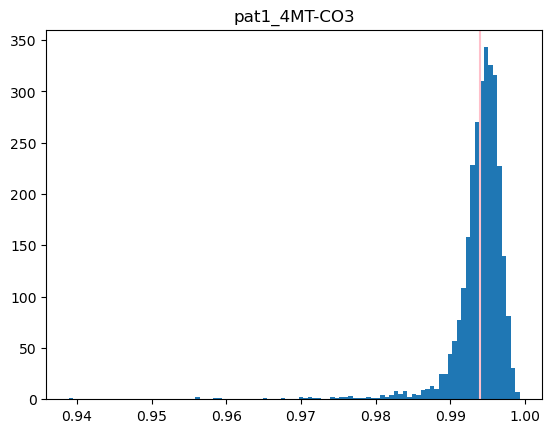

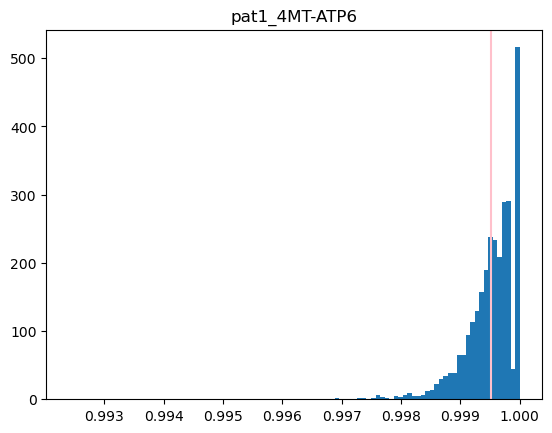

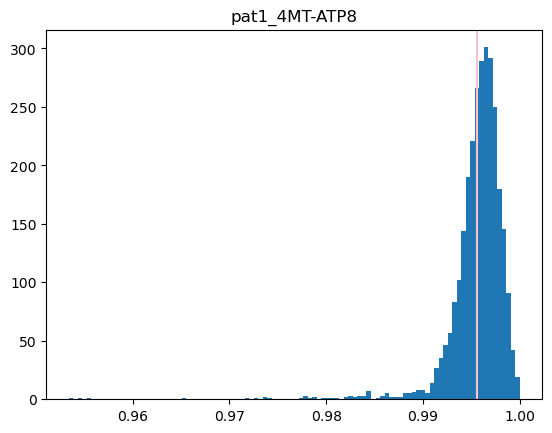

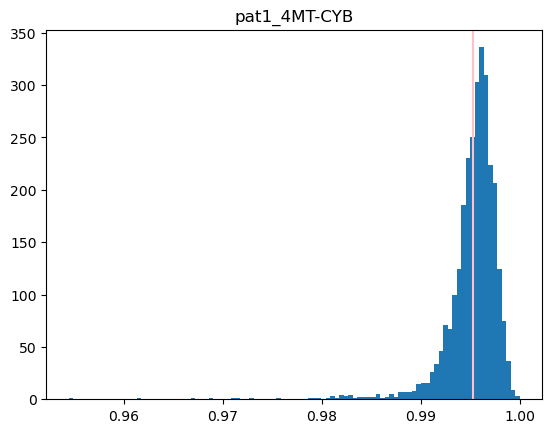

In [206]:
r=1000
uem14_list_n2=[]
for j in intpro:
    uem_sample_list=[]
    for i in range(p14_n2_len):   
        x=p14_n2[j][i]
        uem=(r-1)/(x+r-1)
        uem_sample_list.append(uem)
    uem14_list_n2.append(mean(uem_sample_list))
    #the following plots the distribution of the UEM 
    fig, ax = plt.subplots(1, 1) 
    ax.set_title('pat1_4'+''+j)
    ax.hist(uem_sample_list,bins=100)
    ax.axvline(mean(uem_sample_list), color='pink')
    plt.show()
uem14_list_n2=dict(zip(intpro,uem14_list_n2))

In [212]:
len(uem14_list_n2)

13

Some functions for the χ² tests

In [218]:
#df=dataframe, index_list=list of names of the 13 genes, lam = parameter for the poisson 
def expected_count_nbi(df, index_list, prob,r=100):
    expected_vals=[] #frequency
    expected_ranges=[] #corresponding ranges
    n=len(df)
    for j in index_list:
        li=[]
        ind=[]
        p=prob[j]
        m=floor(min(df[j]))
        M=ceil(max(df[j]))
        low=m
        upp=m+1
        if m==0:
            coun=n*st.nbinom.cdf(m+1,r,p) 
        else: 
            coun=n*(st.nbinom.cdf(m+1,r,p)-st.nbinom.cdf(m-1,r,p))
        if coun>=5:
            ind.append([low,upp])
            li.append(coun)
            low=upp
            upp+=1
            coun=0
        else:
            pass
        for i in range(m+1,M-1,1):
            coun+=n*(st.nbinom.cdf(i+1,r,p)-st.nbinom.cdf(i,r,p))
            if coun>=5: 
                upp=i+1
                ind.append([low,upp])
                li.append(coun)
                coun=0
                low=upp
            else:
                pass
        upp=M
        coun+=n*(st.nbinom.cdf(M,r,p)-st.nbinom.cdf(M-1,r,p))
        if coun>=5:
            ind.append([low,upp])
            li.append(coun)
        else:
            li[-1]=li[-1]+coun
            ind[-1][1]=upp
        expected_vals.append(li)
        expected_ranges.append(ind)
    expected_vals=dict(zip(intpro,expected_vals))
    expected_ranges=dict(zip(intpro,expected_ranges))
    return (expected_vals,expected_ranges)

def ex_vals_nbi(df, index_list, prob,r=100):
    return expected_count_nbi(df, index_list, prob,r)[0]

def ex_range_nbi(df, index_list, prob,r=100):
    return expected_count_nbi(df, index_list, prob,r)[1]

In [219]:
ex_vals_nbi(p14_n2,intpro,uem14_list_n2,r=1000)

{'MT-ND1': [1344.7405653290748,
  771.5283161347618,
  460.6467172406042,
  206.48027316392134,
  74.11599074439901,
  22.19199641799442,
  7.296140969244048],
 'MT-ND2': [2061.046507851216,
  561.3441985744827,
  198.42831610987542,
  52.65899060751532,
  13.521982054913158],
 'MT-ND3': [1828.887738484485,
  657.5964997003682,
  281.0831354189035,
  90.19958943126515,
  23.179128274549925,
  6.053908690243809],
 'MT-ND4': [2371.98317438919,
  392.42716531387407,
  100.07257055237837,
  22.51708779017274],
 'MT-ND4L': [583.3386190264746,
  649.9979803137463,
  645.8115464069541,
  481.71933550972136,
  287.7432327571799,
  143.37296324328614,
  61.293515842158484,
  22.950986025925864,
  10.771820874553208],
 'MT-ND5': [1950.9913675266835,
  610.1797544250616,
  236.90581552118542,
  69.05388620453343,
  19.8691628675315],
 'MT-ND6': [2816.7386071053857, 64.77606015610934, 5.485332113494244],
 'MT-CO1': [168.4507873973148,
  313.9700175485071,
  476.47165347084206,
  542.8507404019198,

In [220]:
ex_range_nbi(p14_n2,intpro,uem14_list_n2,r=1000)

{'MT-ND1': [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 21]],
 'MT-ND2': [[0, 1], [1, 2], [2, 3], [3, 4], [4, 11]],
 'MT-ND3': [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 16]],
 'MT-ND4': [[0, 1], [1, 2], [2, 3], [3, 10]],
 'MT-ND4L': [[0, 1],
  [1, 2],
  [2, 3],
  [3, 4],
  [4, 5],
  [5, 6],
  [6, 7],
  [7, 8],
  [8, 29]],
 'MT-ND5': [[0, 1], [1, 2], [2, 3], [3, 4], [4, 11]],
 'MT-ND6': [[0, 1], [1, 2], [2, 7]],
 'MT-CO1': [[0, 1],
  [1, 2],
  [2, 3],
  [3, 4],
  [4, 5],
  [5, 6],
  [6, 7],
  [7, 8],
  [8, 9],
  [9, 10],
  [10, 11],
  [11, 55]],
 'MT-CO2': [[0, 1],
  [1, 2],
  [2, 3],
  [3, 4],
  [4, 5],
  [5, 6],
  [6, 7],
  [7, 8],
  [8, 9],
  [9, 10],
  [10, 11],
  [11, 12],
  [12, 13],
  [13, 14],
  [14, 15],
  [15, 16],
  [16, 63]],
 'MT-CO3': [[0, 1],
  [1, 2],
  [2, 3],
  [3, 4],
  [4, 5],
  [5, 6],
  [6, 7],
  [7, 8],
  [8, 9],
  [9, 10],
  [10, 11],
  [11, 12],
  [12, 13],
  [13, 14],
  [14, 65]],
 'MT-ATP6': [[0, 1], [1, 2], [2, 8]],
 'MT-ATP8': [[0, 1],
  [1, 2],
 

In [222]:
def obs_count_nbi(df,index_list, prob, r=100):
    comp_ran=ex_range_nbi(df,index_list, prob, r)
    obs_val=[]
    for j in index_list:
        li=[]
        ran=comp_ran[j]
        df_j=df[j]
        l,h=ran[0][0],ran[0][1]
        li.append(len(df_j[(df_j>=l) & (df_j<=h)]))
        for i in range(1,len(ran),1):
            l,h=ran[i][0],ran[i][1]
            li.append(len(df_j[(df_j>l) & (df_j<=h)]))
        obs_val.append(li)
    return dict(zip(index_list,obs_val))
    

In [223]:
obs_count_nbi(p14_n2,intpro,uem14_list_n2,r=1000)

{'MT-ND1': [646, 1317, 642, 180, 49, 17, 36],
 'MT-ND2': [1642, 970, 193, 46, 36],
 'MT-ND3': [1205, 1305, 277, 49, 25, 26],
 'MT-ND4': [2120, 663, 76, 28],
 'MT-ND4L': [128, 688, 953, 634, 262, 97, 49, 23, 53],
 'MT-ND5': [1461, 1088, 255, 46, 37],
 'MT-ND6': [2802, 72, 13],
 'MT-CO1': [41, 258, 543, 653, 492, 368, 173, 137, 68, 49, 21, 84],
 'MT-CO2': [3,
  9,
  56,
  166,
  332,
  438,
  438,
  424,
  330,
  198,
  143,
  88,
  58,
  56,
  22,
  25,
  101],
 'MT-CO3': [5, 42, 158, 401, 557, 536, 440, 296, 156, 102, 52, 33, 18, 16, 75],
 'MT-ATP6': [2579, 275, 33],
 'MT-ATP8': [68, 274, 513, 621, 554, 373, 208, 113, 59, 19, 15, 70],
 'MT-CYB': [16, 150, 399, 679, 616, 449, 227, 145, 70, 36, 28, 72]}

In [224]:
def chi2_res(ex,obs,index_list,alp=0.99):
    import scipy.stats as st
    res=[]
    for j in index_list:
        deg=len(ex)-1
        cv=st.chi2.ppf(alp,deg)
        ele=[(a-b)**2/a for a,b in zip(ex[j],obs[j])]
        ts=sum(ele)
        res.append(ts-cv)
    return res



In [225]:
def chi2_res_nbi(df,index_list, prob, r=100, alp=0.99):
    ex=ex_vals_nbi(df, index_list, prob,r)
    obs=obs_count_nbi(df,index_list, prob, r)
    import scipy.stats as st
    res=[]
    for j in index_list:
        deg=len(ex)-1
        cv=st.chi2.ppf(alp,deg)
        ele=[(a-b)**2/a for a,b in zip(ex[j],obs[j])]
        ts=sum(ele)
        res.append(ts-cv)
    return res



In [226]:
chi2_res_nbi(p14_n1,intpro,uem14_list_n1)

[131.42415990378902,
 264.28918029644944,
 253.73298897037077,
 300.87656481239435,
 113.8127750426811,
 202.3106379413696,
 383.1025710808856,
 4469.486690122474,
 650.206843607468,
 246.8511095000923,
 393.3525346192036,
 1044.2737788051825,
 203.63832541290665]

In [227]:
chi2_res_nbi(p14_n2,intpro,uem14_list_n2,r=1000)

[919.9485026116721,
 394.8383418477495,
 908.7160970016083,
 194.2338076156786,
 710.9996961825096,
 494.86485453621265,
 -15.03945080951946,
 871.1324129257949,
 1059.5118368218639,
 1110.913245855189,
 -4.999336052113961,
 766.3204942713035,
 547.0130856548928]

In [ ]:
#df=dataframe, index_list=list of names of the 13 genes, lam = parameter for the poisson 
def expected_count_gam(df, index_list, r):
    expected_vals=[] #frequency
    expected_ranges=[] #corresponding ranges
    n=len(df)
    for j in index_list:
        li=[]
        ind=[]
        p=uem14_list_n1[j]
        m=floor(min(p14_n1[j]))
        M=ceil(max(p14_n1[j]))
        low=m
        upp=m+1
        if m==0:
            coun=n*st.poisson.cdf(m+1,lam) 
        else: 
            coun=n*(st.poisson.cdf(m+1,lam)-st.nbinom.cdf(m-1,lam))
        if coun>=5:
            ind.append([low,upp])
            li.append(coun)
            low=upp
            upp+=1
            coun=0
        else:
            pass
        for i in range(m+1,M-1,1):
            coun+=n*(st.poisson.cdf(i+1,lam)-st.nbinom.cdf(i,lam))
            if coun>=5: 
                upp=i+1
                ind.append([low,upp])
                li.append(coun)
                coun=0
                low=upp
            else:
                pass
        upp=M
        coun+=n*(st.poisson.cdf(M,lam)-st.nbinom.cdf(M-1,lam))
        if coun>=5:
            ind.append([low,upp])
            li.append(coun)
        else:
            li[-1]=li[-1]+coun
            ind[-1][1]=upp
        expected_vals.append(li)
        expected_ranges.append(ind)
    expected_vals=dict(zip(intpro,expected_vals))
    expected_ranges=dict(zip(intpro,expected_ranges))

Now to tabulate expected table aka frequency of expected values corresponding to the ranges. 

In [ ]:
p14_n1_chi_ex=[]
p14_n1_chi_ind=[]
n=len(p14_n1)
for j in intpro:
    li=[]
    ind=[]
    p=uem14_list_n1[j]
    m=floor(min(p14_n1[j]))
    M=ceil(max(p14_n1[j]))
    low=m
    upp=m+1
    if m==0:
        coun=n*st.nbinom.cdf(m+1,100,p) 
    else: 
        coun=n*(st.nbinom.cdf(m+1,100,p)-st.nbinom.cdf(m-1,100,p))
    if coun>=5:
        ind.append([low,upp])
        li.append(coun)
        low=upp
        upp+=1
        coun=0
    else:
        pass
    for i in range(m+1,M-1,1):
        coun+=n*(st.nbinom.cdf(i+1,100,p)-st.nbinom.cdf(i,100,p))
        if coun>=5: 
            upp=i+1
            ind.append([low,upp])
            li.append(coun)
            coun=0
            low=upp
        else:
            pass
    upp=M
    coun+=n*(st.nbinom.cdf(M,100,p)-st.nbinom.cdf(M-1,100,p))
    if coun>=5:
        ind.append([low,upp])
        li.append(coun)
    else:
        li[-1]=li[-1]+coun
        ind[-1][1]=upp
    p14_n1_chi_ex.append(li)
    p14_n1_chi_ind.append(ind)
p14_n1_chi_ex=dict(zip(intpro,p14_n1_chi_ex))
p14_n1_chi_ind=dict(zip(intpro,p14_n1_chi_ind))

In [ ]:
p14_n1_chi_ex

In [ ]:
p14_n1_chi_obs=[]
p14_n1_chi_ind=[]
for j in intpro:
    li=[]
    ind=[]
    m=floor(min(p14_n1[j]))
    M=ceil(max(p14_n1[j]))
    d=M-m
    df_data=p14_n1[j]
    coun=len(df_data[(df_data>=m) & (df_data<=m+1)])
    low=m
    upp=m+1
    if coun>=5:
        ind.append([low,upp])
        li.append(coun)
        low=upp
        upp+=1
        coun=0
    else:
        pass
    for i in range(m+1,M-1,1):
        coun+=len(df_data[(df_data>i) & (df_data<=i+1)])
        if coun>=5:
            upp=i+1
            ind.append([low,upp])
            li.append(coun)
            coun=0
            low=upp
        else:
            pass
    upp=M
    coun+=len(df_data[(df_data>=M-1) & (df_data<=M)])
    if coun>=5:
        ind.append([low,upp])
        li.append(coun)
    else:
        li[-1]=li[-1]+coun
        ind[-1][1]=upp
    p14_n1_chi_obs.append(li)
    p14_n1_chi_ind.append(ind)
p14_n1_chi_obs=dict(zip(intpro,p14_n1_chi_obs))
p14_n1_chi_ind=dict(zip(intpro,p14_n1_chi_ind))
p14_n1_chi_ind

In [ ]:
p14_n1_chi_obs=[]
p14_n1_chi_ind=[]
for j in intpro:
    li=[]
    ind=[]
    m=floor(min(p14_n1[j]))
    M=ceil(max(p14_n1[j]))
    d=M-m
    df_data=p14_n1[j]
    coun=len(df_data[(df_data>=m) & (df_data<=m+1)])
    low=m
    upp=m+1
    if coun>=5:
        ind.append([low,upp])
        li.append(coun)
        low=upp
        upp+=1
        coun=0
    else:
        pass
    for i in range(m+1,M-1,1):
        coun+=len(df_data[(df_data>i) & (df_data<=i+1)])
        if coun>=5:
            upp=i+1
            ind.append([low,upp])
            li.append(coun)
            coun=0
            low=upp
        else:
            pass
    upp=M
    coun+=len(df_data[(df_data>=M-1) & (df_data<=M)])
    if coun>=5:
        ind.append([low,upp])
        li.append(coun)
    else:
        li[-1]=li[-1]+coun
        ind[-1][1]=upp
    p14_n1_chi_obs.append(li)
    p14_n1_chi_ind.append(ind)
p14_n1_chi_obs=dict(zip(intpro,p14_n1_chi_obs))
p14_n1_chi_ind=dict(zip(intpro,p14_n1_chi_ind))
p14_n1_chi_ind

In [ ]:
p14_n1_chi_obs['MT-CO1']

In [ ]:
p14_n1_chi_ind['MT-CO1']

Expected value

In [ ]:
r=100
p14_n1_chi_exp=[]
for j in intpro:
    p=uem14_list_n1[j]
    ra_list=p14_n1_chi_ind[j]
    expe=[]
    for i in range(len(p14_n1_chi_ind[j])):
        a,b=ra_list[i][0],ra_list[i][1]
        expe.append(2887*(st.nbinom.cdf(b,r,p)-st.nbinom.cdf(a,r,p)))
    p14_n1_chi_exp.append(expe)
p14_n1_chi_exp=dict(zip(intpro,p14_n1_chi_exp))
p14_n1_chi_exp

In [ ]:
len(p14_n1_chi_obs['MT-CO1'])

Calculating test stat and critical value. Thereafter concluding:

In [ ]:
p14_n1_chi_cv=[]
p14_n1_chi_ts=[]
p14_n1_chi_res=[]
for j in intpro:
    df=len(p14_n1_chi_obs[j])-1
    cv=st.chi2.ppf(0.99,df)
    p14_n1_chi_cv.append(cv)
    ele=[(a-b)**2/a for a,b in zip(p14_n1_chi_exp[j],p14_n1_chi_obs[j])]
    ts=sum(ele)
    p14_n1_chi_ts.append(ts)
    p14_n1_chi_res.append(ts-cv)
p14_n1_chi_res

In [ ]:
def obscount(index_list, df):
    obs_val=[]
    obs_ind=[]
    for j in index_list:
        li=[]
        ind=[]
        m=floor(min(df[j]))
        M=ceil(max(df[j]))
        d=M-m
        df_data=df[j]
        coun=len(df_data[(df_data>=m) & (df_data<=m+1)])
        low=m
        upp=m+1
        if coun>=5:
            ind.append([low,upp])
            li.append(coun)
            low=upp
            upp+=1
            coun=0
        else:
            pass
        for i in range(m+1,M-1,1):
            coun+=len(df_data[(df_data>i) & (df_data<=i+1)])
            if coun>=5:
                upp=i+1
                ind.append([low,upp])
                li.append(coun)
                coun=0
                low=upp
            else:
                pass
        upp=M
        coun+=len(df_data[(df_data>=M-1) & (df_data<=M)])
        if coun>=5:
            ind.append([low,upp])
            li.append(coun)
        else:
            li[-1]=li[-1]+coun
            ind[-1][1]=upp
        obs_val.append(li)
        obs_ind.append(ind)
    obs_val=dict(zip(index_list,obs_val))
    obs_ind=dict(zip(intpro,obs_ind))